In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib as mpl
import os
import glob
from timeit import default_timer as timer
import sys
from numba import njit
from scipy.stats import gaussian_kde,iqr

mpl.rcParams['figure.dpi'] = 300

#### MSD Libs #######
@njit
def self_nofft(r):
    """Compute the self MSD from a single particle trajectory using a double loop."""
    N = r.shape[0]
    lags = np.arange(N)
    msd = np.zeros(lags.size)    
    # compute sepeartely for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            continue
        dr = r[:-lag] - r[lag:]
        dr2 = np.square(dr).sum(axis=1)
        msd[i] = dr2.mean()
    return msd

@njit
def dist_nofft(r1, r2):
    """Compute the distinct particles MSD from a single particle trajectory
using a double loop.
    """
    N = r1.shape[0]
    lags = np.arange(N)
    msd = np.zeros(lags.size)    
    # compute sepeartely for each lag
    for i, lag in enumerate(lags):
        if lag == 0:
            r = r1 - r2
            continue
        dr = r[:-lag] - r[lag:]
        dr2 = np.square(dr).sum(axis=1)
        msd[i] = dr2.mean()
    return msd

def _autocorr_fft(x):
    """Compute the autocorrelation of 1d signal using FFT."""
    N = x.shape[0]
    # 2*N because of zero-padding to compute non-cyclic correlation
    f = np.fft.fft(x, n=2*N)
    power_spectrum = f * f.conjugate()
    result = np.fft.ifft(power_spectrum)
    # the autocorrelation in the usual convention B
    result = (result[:N]).real
    return result

@njit 
def _msd_fft_compute_s1(r):
    """Compute the non-FFT part of the MSD in the FFT method."""
    N = r.shape[0]
    # Compute the squared distances
    D = np.square(r).sum(axis=1)
    # Apply the recursive algorithm
    s1 = np.zeros(N)
    s1[0] = 2*D.sum()
    for n in range(1, N):
        s1[n] = s1[n-1] - D[n-1] - D[N-n]
    return s1

def self_fft(r):
    """Compute the self MSD from a single particle trajectory using FFT.

    Based on the algorithm outlined in Section 4.2 of the following paper:
    https://doi.org/10.1051/sfn/201112010
    """
    N = r.shape[0]
    # Compute the non-FFT part
    s1 = _msd_fft_compute_s1(r)
    # Compute the FFT-part separately over each position component
    s2 = np.zeros_like(s1)
    for i in range(r.shape[1]):
        s2 += _autocorr_fft(r[:, i])
    return (s1 - 2*s2) / np.arange(N, 0, -1)

def dist_fft(r1, r2):
    """Compute the dist MSD from a single particle trajectory using FFT."""
    return self_fft(r1 - r2)

def read_h (files):
    #### Read Header File, getting number of particles, box size, timestep #######
    f=open(files[0],'r')
    trash = f.readline()
    trash = f.readline()
    elems = str.split(trash.strip()," ") 
    #  print (str.isdigit(elems[0]))
    if str.isdigit(elems[0])==True:
        #print ("yay")
        time1 = float(elems[0])/1
        trash = f.readline() 
        trash = f.readline()
        elems = str.split(trash," ") 
        npart = int(elems[0]);
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        elems = str.split(trash," ")
        mybox = float(elems[1])-float(elems[0])
        trash = f.readline()
    #### Read Header File of second file, getting number of particles, box size, timestep #######
    f=open(files[1],'r')
    trash = f.readline()
    trash = f.readline()
    elems = str.split(trash.strip()," ") 
    #  print (str.isdigit(elems[0]))
    if str.isdigit(elems[0])==True:
        #print ("yay")
        time2 = float(elems[0])/1
        trash = f.readline() 
        trash = f.readline()
        elems = str.split(trash," ") 
        npart = int(elems[0]);
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        trash = f.readline()
        elems = str.split(trash," ")
        mybox = float(elems[1])-float(elems[0])
        trash = f.readline()
    framestep=int(time2-time1)
    return framestep, npart, mybox


def CoM (out,npart): #### Calculates CoM of particles takes as input unwrapped data, box and #of particles ############
    comx=np.sum(out[:,1])
    comy=np.sum(out[:,2])
    comz=np.sum(out[:,3])
    com = np.array([comx,comy,comz])/(npart)
    return com

@njit(fastmath=True,)      
def compute_rg(data,com):
    temp=0
    for i in range (data[:,0].size):
        xx=np.abs(data[i,1]-com[0])
        yy=np.abs(data[i,2]-com[1])
        zz=np.abs(data[i,3]-com[2])
        temp=temp+xx*2+yy**2+zz**2
    temp=temp/data[:,0].size
    #print(temp)
    return temp

# pos = np.zeros((len(traj), Number_of_particles, 3)) #in this array you load the particle positions. traj is the trajectory, i.e. it has len = number of snapshots
# time = np.zeros(len(traj))
# pos -= pos.mean(axis=1).reshape(-1, 1, 3)# Subtracts the global mean - !important because Langevin can cause it's radom diffusion - unphysical!
# msds = np.zeros((N, len(traj)))
# for i in trange(pos.shape[1]):
#     msds[i] = self_fft(pos[:,i])
# plt.loglog(time[1:], msds.mean(axis=0)[1:])




In [23]:
wdir="data_equil*/"
wfile="log.stress"
files=glob.glob(wdir)
print(files)



['data_equil\\', 'data_equil_1\\', 'data_equil_2\\']


In [29]:
filename=files[0]+wfile
data=np.genfromtxt(filename)
filename=files[1]+wfile
data+=np.genfromtxt(filename)
filename=files[2]+wfile
data+=np.genfromtxt(filename)
test_data=np.genfromtxt(filename)

Text(0, 0.5, 'τ [k$_b$T/σ$^3$]')

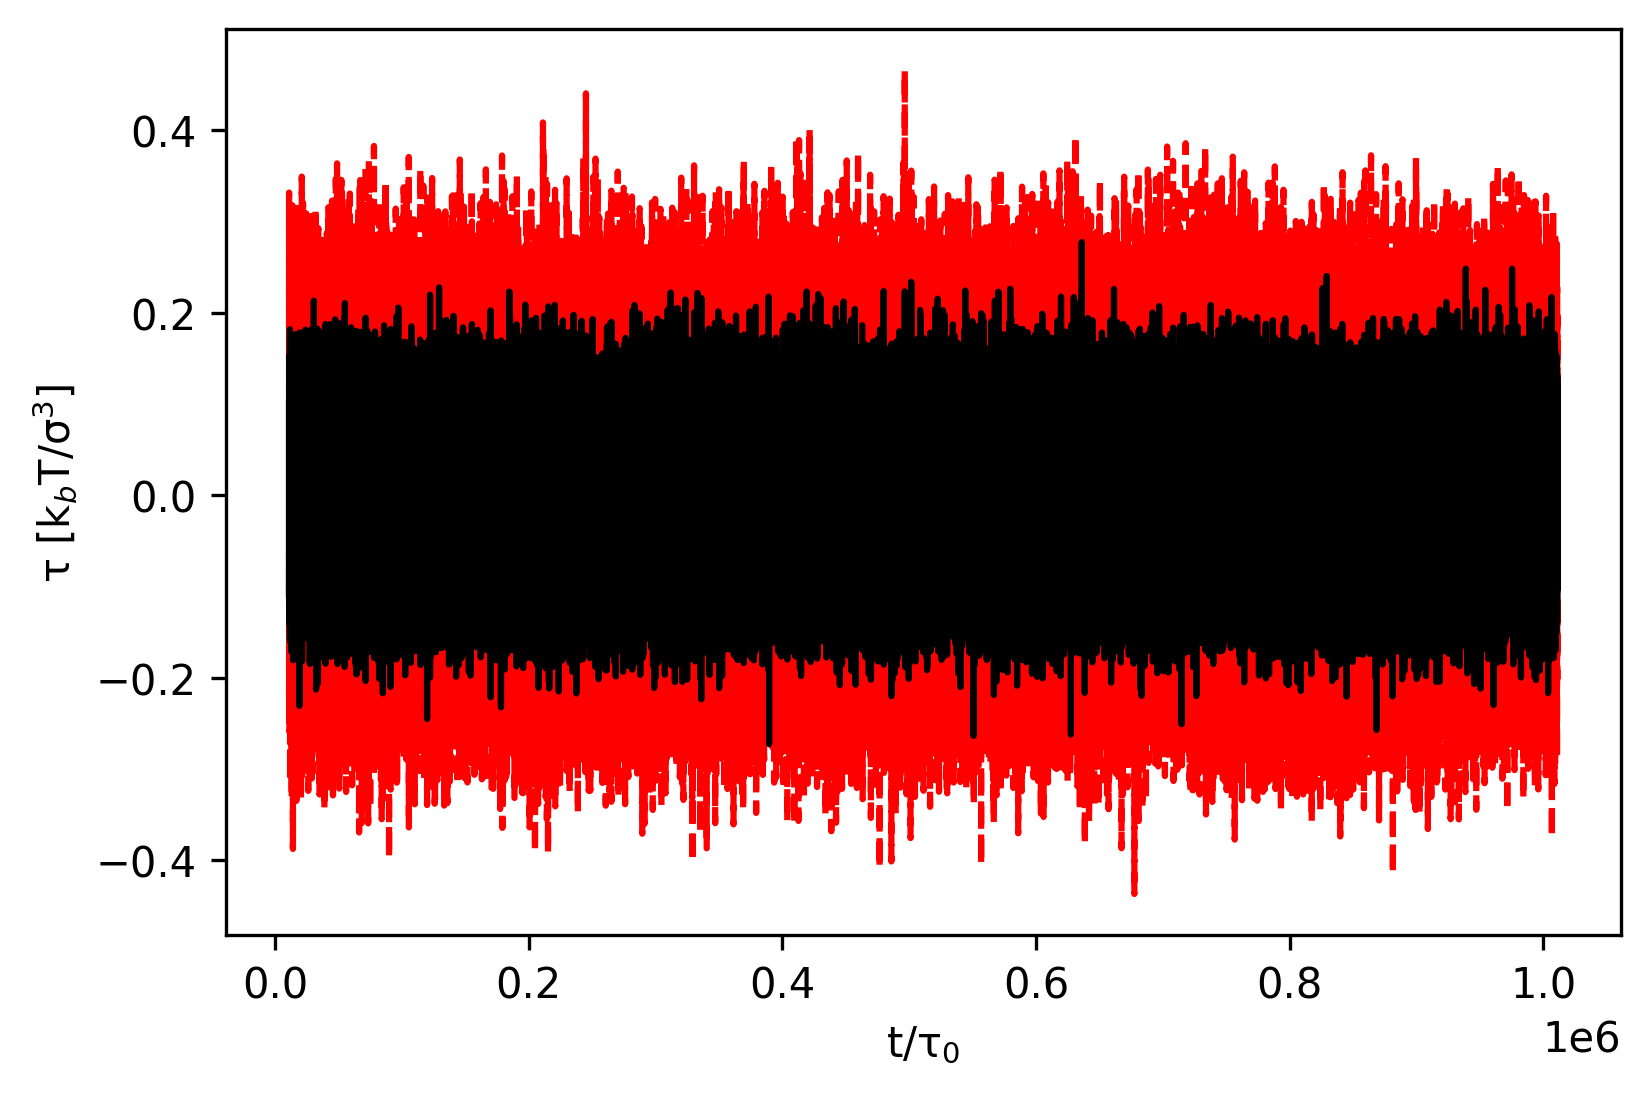

In [32]:
plt.plot(test_data[:,0]*0.01,test_data[:,1],'r--')
plt.plot((data[:,0]/3)*0.01,(data[:,1])/3,'k-')
plt.xlabel('t/τ$_0$')
plt.ylabel('τ [k$_b$T/σ$^3$]')

In [40]:
stress_autocorr=_autocorr_fft(data[:,1]/3)
test_autocorr=_autocorr_fft(test_data[:,1])

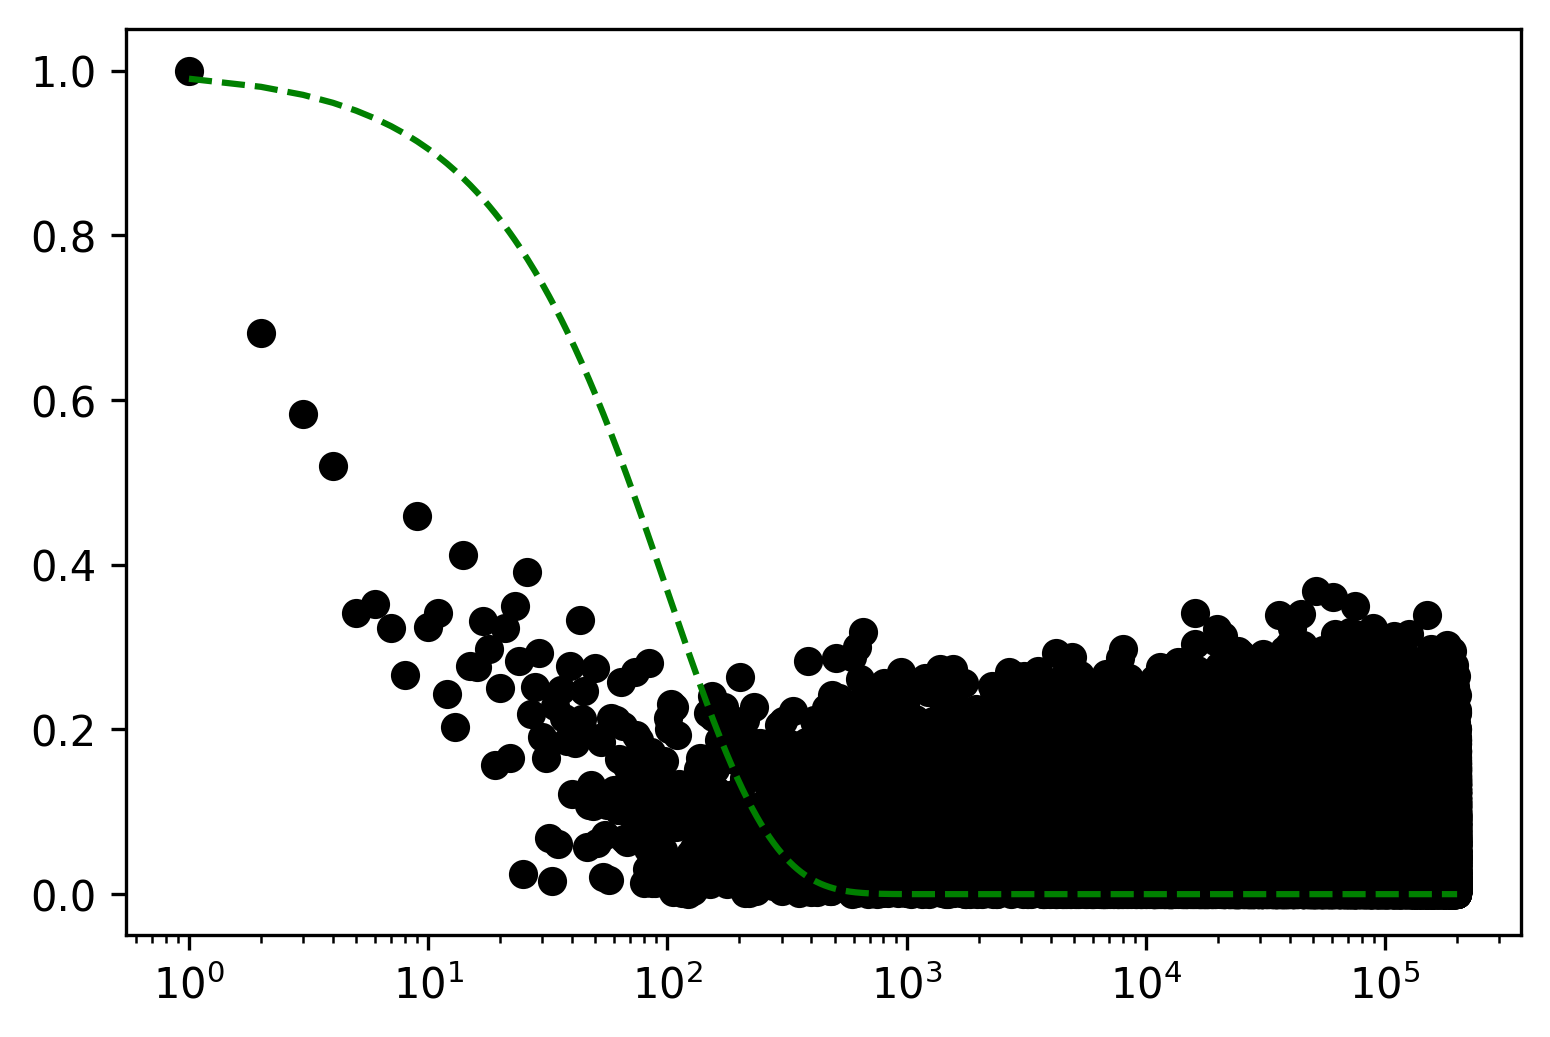

In [106]:
upto=200000
t=((data[1:upto,0]-data[0,0])/3)*0.01
t0=100
#plt.plot(t,np.abs(test_autocorr[1:upto])/test_autocorr[1],'ro')
plt.plot(t,np.abs(stress_autocorr[1:upto])/stress_autocorr[1],'ko')
plt.plot(t,np.exp(-t/t0),'g--')
plt.xscale('log')
#plt.yscale('log')

In [14]:
stress_autocorr

array([ 8.08039992e+03,  9.47916780e+01,  7.15272053e+01, ...,
        2.40784532e-02,  5.41937963e-03, -5.99317854e-03])

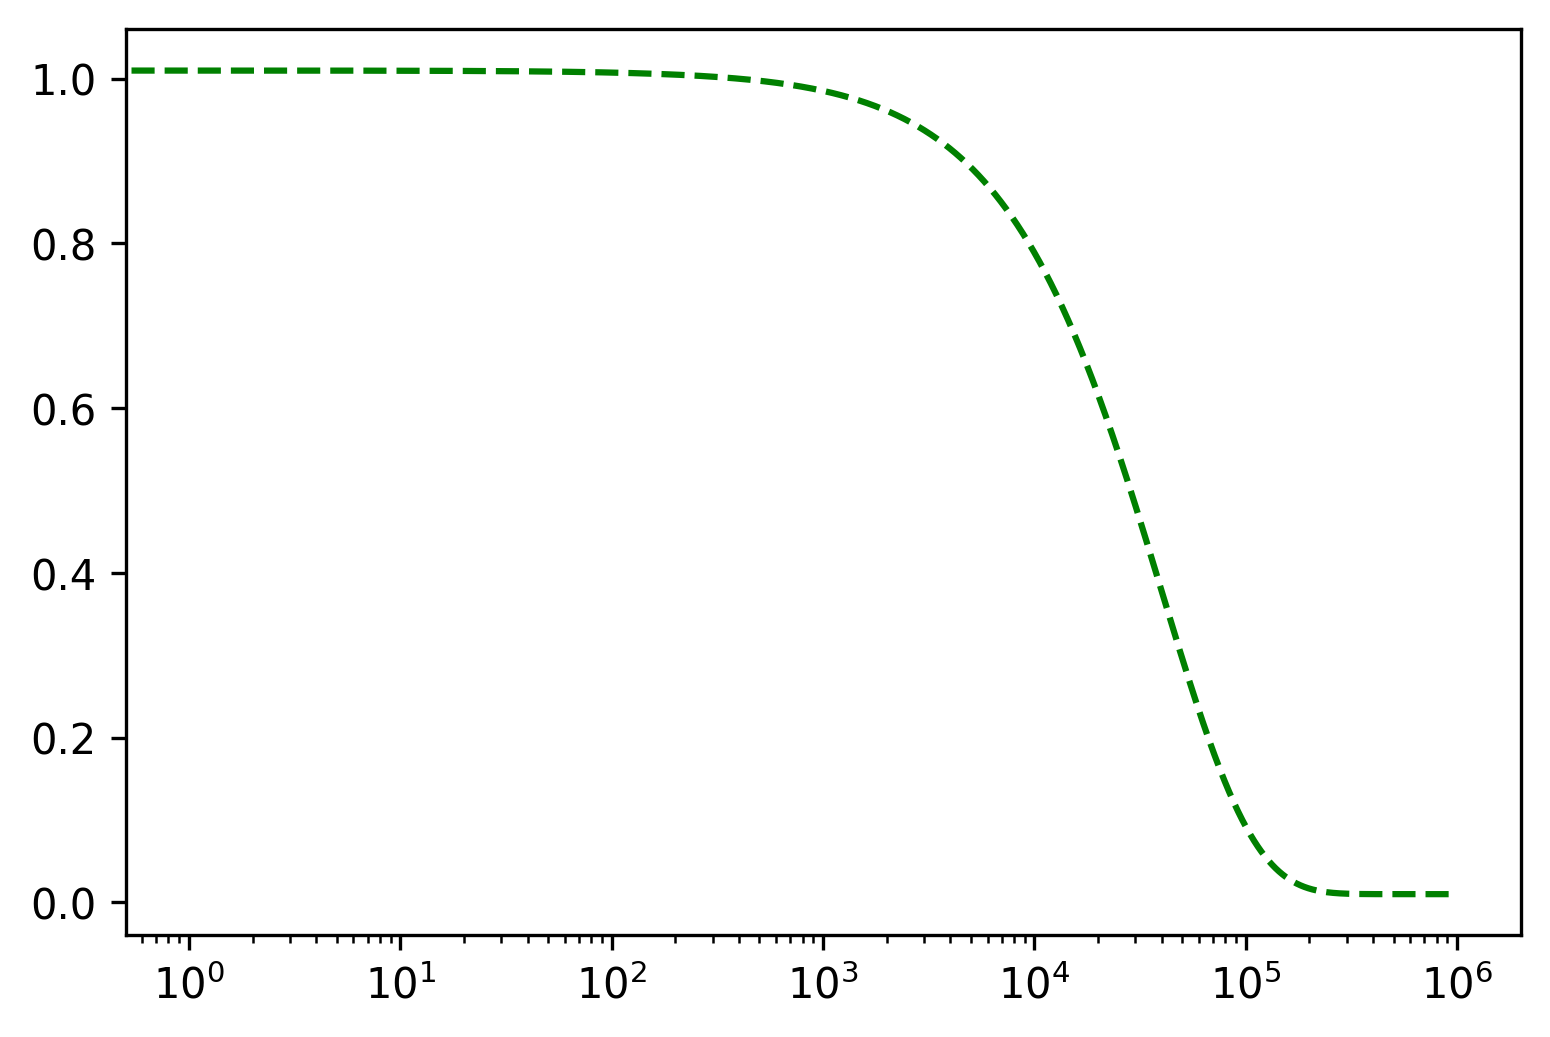

In [94]:

t0=40000
plt.plot(t,1*np.exp(-t/t0)+0.01,'g--')
plt.xscale('log')

In [93]:
t

array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 9.99998e+05,
       9.99999e+05, 1.00000e+06])